In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keplergl import KeplerGl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from IPython.display import Image
import pydotplus
#import graphviz
import librosa
import librosa.display


sns.set_style('dark')
plt.style.use('dark_background')

In [2]:
# Features Database was extracted via the Librosa db
features = pd.read_csv('/Users/DanCassin/Development/python/Notebooks/Thinkful/Supervised_Learning_Data/fma_metadata/features.csv',
                low_memory=False, index_col=0, header=[0, 1, 2])

In [3]:
pd.set_option('precision', 2, 'max_columns', None)

features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 422.0 MB


feature    chroma_cens                                                        \
statistics    kurtosis                                                         
number              01    02    03    04    05    06    07    08    09    10   
track_id                                                                       
2                 7.18  5.23  0.25  1.35  1.48  0.53  1.48  2.69  0.87  1.34   
3                 1.89  0.76  0.35  2.30  1.65  0.07  1.37  1.05  0.11  0.62   
5                 0.53 -0.08 -0.28  0.69  1.94  0.88 -0.92 -0.93  0.67  1.04   
10                3.70 -0.29  2.20 -0.23  1.37  1.00  1.77  1.60  0.52  1.98   
20               -0.19 -0.20  0.20  0.26  0.78  0.08 -0.29 -0.82  0.04 -0.80   

feature                                                                       \
statistics               max                                                   
number        11    12    01    02    03    04    05    06    07    08    09   
track_id                                                                       
2           1.35  1.24  0.69  0.57  0.60  0.63  0.57  0.44  0.49  0.50  0.57   
3           1.04  1.29  0.68  0.58  0.58  0.58  0.45  0.46  0.54  0.66  0.51   
5           0.27  1.13  0.61  0.65  0.49  0.45  0.47  0.45  0.50  0.56  0.67   
10          4.33  1.30  0.46  0.54  0.45  0.65  0.59  0.51  0.65  0.52  0.51   
20         -0.99 -0.43  0.65  0.68  0.67  0.60  0.65  0.70  0.66  0.69  0.64   

feature                                                                       \
statistics                    mean                                             
number        10    11    12    01    02    03    04    05    06    07    08   
track_id                                                                       
2           0.58  0.62  0.59  0.47  0.37  0.24  0.23  0.22  0.22  0.23  0.25   
3           0.53  0.60  0.55  0.23  0.23  0.23  0.22  0.22  0.24  0.37  0.42   
5           0.61  0.55  0.60  0.26  0.30  0.25  0.22  0.25  0.24  0.28  0.29   
10          0.48  0.64  0.64  0.23  0.29  0.24  0.23  0.19  0.29  0.41  0.35   
20          0.67  0.69  0.68  0.20  0.25  0.26  0.19  0.18  0.24  0.28  0.29   

feature                                                                        \
statistics                         median                                       
number        09    10    11    12     01    02    03    04    05    06    07   
track_id                                                                        
2           0.20  0.18  0.20  0.32   0.48  0.39  0.25  0.24  0.23  0.23  0.23   
3           0.31  0.24  0.26  0.23   0.23  0.23  0.21  0.20  0.23  0.26  0.39   
5           0.35  0.29  0.25  0.22   0.26  0.29  0.25  0.22  0.25  0.24  0.28   
10          0.27  0.24  0.27  0.24   0.23  0.28  0.23  0.23  0.21  0.28  0.44   
20          0.25  0.29  0.30  0.24   0.20  0.22  0.23  0.19  0.16  0.24  0.26   

feature                                                                       \
statistics                                     min                             
number        08    09    10    11    12        01        02    03   04   05   
track_id                                                                       
2           0.25  0.20  0.17  0.20  0.31  0.00e+00  0.00e+00  0.00  0.0  0.0   
3           0.44  0.31  0.24  0.26  0.23  0.00e+00  0.00e+00  0.00  0.0  0.0   
5           0.29  0.35  0.28  0.24  0.21  0.00e+00  0.00e+00  0.00  0.0  0.0   
10          0.36  0.27  0.24  0.25  0.23  3.35e-04  2.52e-03  0.01  0.0  0.0   
20          0.27  0.24  0.27  0.29  0.24  0.00e+00  0.00e+00  0.00  0.0  0.0   

feature                                                                       \
statistics                                                    skew             
number       06        07        08   09   10        11   12    01        02   
track_id                                                                       
2           0.0  0.00e+00  0.00e+00  0.0  0.0  0.00e+00  0.0 -2.00

In [4]:
# Tracks contains the metadata of all the music files. Certain columns chosen.
tracks = pd.read_csv('/Users/DanCassin/Development/python/Notebooks/Thinkful/Supervised_Learning_Data/fma_metadata/tracks.csv',
                    low_memory=False, skiprows=[0,2], index_col=0,
                    usecols=[0,2,3,22,23,24,26,32,38,40,52]
                    )

In [5]:
tracks.info()
tracks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date_created   103045 non-null  object 
 1   date_released  70294 non-null   object 
 2   latitude       44544 non-null   float64
 3   location       70210 non-null   object 
 4   longitude      44544 non-null   float64
 5   name           106574 non-null  object 
 6   subset         106574 non-null  object 
 7   duration       106574 non-null  int64  
 8   genre_top      49598 non-null   object 
 9   title.1        106573 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 8.9+ MB


,date_created,date_released,latitude,location,longitude,name,subset,duration,genre_top,title.1
2,2008-11-26 01:44:45,2009-01-05 00:00:00,40.06,New Jersey,-74.41,AWOL,small,168,Hip-Hop,Food
3,2008-11-26 01:44:45,2009-01-05 00:00:00,40.06,New Jersey,-74.41,AWOL,medium,237,Hip-Hop,Electric Ave
5,2008-11-26 01:44:45,2009-01-05 00:00:00,40.06,New Jersey,-74.41,AWOL,small,206,Hip-Hop,This World
10,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,NaN,NaN,Kurt Vile,small,161,Pop,Freeway
20,2008-11-26 01:45:05,2009-01-06 00:00:00,51.90,Colchester England,0.89,Nicky Cook,large,311,NaN,Spiritual Level


### Locations of Artists

In [6]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'qrulzi',
     'type': 'point',
     'config': {'dataId': 'Artist_Locations',
      'label': 'Location',
      'color': [30, 150, 190],
      'columns': {'lat': 'latitude', 'lng': 'longitude', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.19,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Uber Viz Qualitative 3',
        'type': 'qualitative',
        'category': 'Uber',
        'colors': ['#12939A',
         '#DDB27C',
         '#88572C',
         '#FF991F',
         '#F15C17',
         '#223F9A',
         '#DA70BF',
         '#125C77',
         '#4DC19C',
         '#776E57',
         '#17B8BE',
         '#F6D18A',
         '#B7885E',
         '#FFCB99',
         '#F89570']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'genre_top', 'type': 'string'},
      'colorScale': 'ordinal',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'Artist_Locations': ['date_released',
       'location',
       'name',
       'genre_top',
        'title.1']},
     'enabled': True},
    'brush': {'size': 23.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 19.56981491943249,
   'longitude': 10.511586077423015,
   'pitch': 0,
   'zoom': 0.7143720653520246,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

#Create a basemap 
map = KeplerGl(height=400, width=1400, config=config)
map.add_data(data=tracks.dropna(), name='Artist_Locations')
map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'qrulzi', 'type': '…

In [7]:
merged = pd.merge(features, tracks[['subset','duration','genre_top']], left_index=True, right_index=True)

merged.head()

/Users/DanCassin/Development/python/python/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)","(chroma_cens, kurtosis, 11)","(chroma_cens, kurtosis, 12)","(chroma_cens, max, 01)","(chroma_cens, max, 02)","(chroma_cens, max, 03)","(chroma_cens, max, 04)","(chroma_cens, max, 05)","(chroma_cens, max, 06)","(chroma_cens, max, 07)","(chroma_cens, max, 08)","(chroma_cens, max, 09)","(chroma_cens, max, 10)","(chroma_cens, max, 11)","(chroma_cens, max, 12)","(chroma_cens, mean, 01)","(chroma_cens, mean, 02)","(chroma_cens, mean, 03)","(chroma_cens, mean, 04)","(chroma_cens, mean, 05)","(chroma_cens, mean, 06)","(chroma_cens, mean, 07)","(chroma_cens, mean, 08)","(chroma_cens, mean, 09)","(chroma_cens, mean, 10)","(chroma_cens, mean, 11)","(chroma_cens, mean, 12)","(chroma_cens, median, 01)","(chroma_cens, median, 02)","(chroma_cens, median, 03)","(chroma_cens, median, 04)","(chroma_cens, median, 05)","(chroma_cens, median, 06)","(chroma_cens, median, 07)","(chroma_cens, median, 08)","(chroma_cens, median, 09)","(chroma_cens, median, 10)","(chroma_cens, median, 11)","(chroma_cens, median, 12)","(chroma_cens, min, 01)","(chroma_cens, min, 02)","(chroma_cens, min, 03)","(chroma_cens, min, 04)","(chroma_cens, min, 05)","(chroma_cens, min, 06)","(chroma_cens, min, 07)","(chroma_cens, min, 08)","(chroma_cens, min, 09)","(chroma_cens, min, 10)","(chroma_cens, min, 11)","(chroma_cens, min, 12)","(chroma_cens, skew, 01)","(chroma_cens, skew, 02)","(chroma_cens, skew, 03)","(chroma_cens, skew, 04)","(chroma_cens, skew, 05)","(chroma_cens, skew, 06)","(chroma_cens, skew, 07)","(chroma_cens, skew, 08)","(chroma_cens, skew, 09)","(chroma_cens, skew, 10)","(chroma_cens, skew, 11)","(chroma_cens, skew, 12)","(chroma_cens, std, 01)","(chroma_cens, std, 02)","(chroma_cens, std, 03)","(chroma_cens, std, 04)","(chroma_cens, std, 05)","(chroma_cens, std, 06)","(chroma_cens, std, 07)","(chroma_cens, std, 08)","(chroma_cens, std, 09)","(chroma_cens, std, 10)","(chroma_cens, std, 11)","(chroma_cens, std, 12)","(chroma_cqt, kurtosis, 01)","(chroma_cqt, kurtosis, 02)","(chroma_cqt, kurtosis, 03)","(chroma_cqt, kurtosis, 04)","(chroma_cqt, kurtosis, 05)","(chroma_cqt, kurtosis, 06)","(chroma_cqt, kurtosis, 07)","(chroma_cqt, kurtosis, 08)","(chroma_cqt, kurtosis, 09)","(chroma_cqt, kurtosis, 10)","(chroma_cqt, kurtosis, 11)","(chroma_cqt, kurtosis, 12)","(chroma_cqt, max, 01)","(chroma_cqt, max, 02)","(chroma_cqt, max, 03)","(chroma_cqt, max, 04)","(chroma_cqt, max, 05)","(chroma_cqt, max, 06)","(chroma_cqt, max, 07)","(chroma_cqt, max, 08)","(chroma_cqt, max, 09)","(chroma_cqt, max, 10)","(chroma_cqt, max, 11)","(chroma_cqt, max, 12)","(chroma_cqt, mean, 01)","(chroma_cqt, mean, 02)","(chroma_cqt, mean, 03)","(chroma_cqt, mean, 04)","(chroma_cqt, mean, 05)","(chroma_cqt, mean, 06)","(chroma_cqt, mean, 07)","(chroma_cqt, mean, 08)","(chroma_cqt, mean, 09)","(chroma_cqt, mean, 10)","(chroma_cqt, mean, 11)","(chroma_cqt, mean, 12)","(chroma_cqt, median, 01)","(chroma_cqt, median, 02)","(chroma_cqt, median, 03)","(chroma_cqt, median, 04)","(chroma_cqt, median, 05)","(chroma_cqt, median, 06)","(chroma_cqt, median, 07)","(chroma_cqt, median, 08)","(chroma_cqt, median, 09)","(chroma_cqt, median, 10)","(chroma_cqt, median, 11)","(chroma_cqt, median, 12)","(chroma_cqt, min, 01)","(chroma_cqt, min, 02)","(chroma_cqt, min, 03)","(chroma_cqt, min, 04)","(chroma_cqt, min, 05)","(chroma_cqt, min, 06)","(chroma_cqt, min, 07)","(chroma_cqt, min, 08)","(chroma_cqt, min, 09)","(chroma_cqt, min, 10)","(chroma_cqt, min, 11)","(chroma_cqt, min, 12)","(chroma_cqt, skew, 01)","(chroma_cqt, skew, 02)","(chroma_cqt, skew, 03)","(chroma_cqt, skew, 04)","(chroma_cqt, skew, 05)","(chroma_cqt, skew, 06)","(chroma_cqt, skew, 07)","(chroma_cqt, skew, 08)","(chroma_cqt, skew, 09)","(chro

In [8]:
# Determining all columns with nulls. Our target is the only column.
merged.columns[merged.isna().any()]

Index(['genre_top'], dtype='object')

In [9]:
# Dropping all nulls as we are only interested in the rows with genres for classification
with_genres = merged.copy()
with_genres = with_genres.dropna(axis=0)

with_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49598 entries, 2 to 155319
Columns: 521 entries, ('chroma_cens', 'kurtosis', '01') to genre_top
dtypes: float64(518), int64(1), object(2)
memory usage: 197.5+ MB


In [10]:
# Looking at all genres provided
with_genres.genre_top.unique()


array(['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz',
       'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues',
       'Country', 'Classical', 'Old-Time / Historic', 'Instrumental',
       'Easy Listening'], dtype=object)

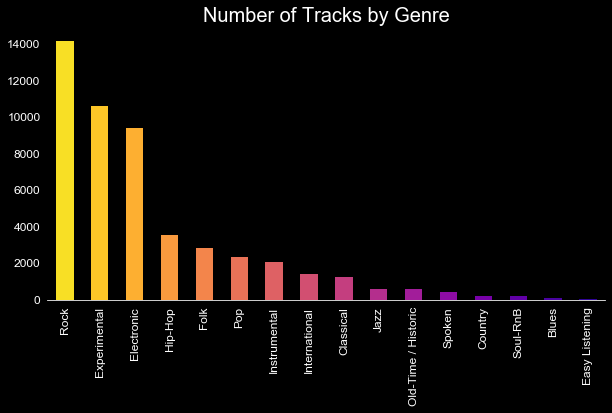

In [59]:
# Seeing the counts of all genres
genre_counts = with_genres.genre_top.value_counts()

# Plotting
fig,ax = plt.subplots(figsize=(10,5))
genre_counts.plot(kind='bar', color=sns.color_palette('plasma_r', len(genre_counts)), linewidth=0)
ax.set_title('Number of Tracks by Genre', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
# Data is biased towards rock, experimental and electronic

In [102]:
# Predicting the genre of music will be our main goal
# Factorizing the dependent variable since they are strings
factorize = pd.factorize(with_genres.genre_top)
with_genres['factorized_genres'] = factorize[0]
definitions = factorize[1]

In [103]:
print(with_genres['genre_top'].unique())
print(with_genres['factorized_genres'].unique())

['Hip-Hop' 'Pop' 'Rock' 'Experimental' 'Folk' 'Jazz' 'Electronic' 'Spoken'
 'International' 'Soul-RnB' 'Blues' 'Country' 'Classical'
 'Old-Time / Historic' 'Instrumental' 'Easy Listening']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [107]:
# Setting up the model
X = with_genres.iloc[:,:-2].drop(['subset', 'genre_top'], axis=1)
Y = with_genres['factorized_genres']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

In [108]:
# Running random forest classifier
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy')
classifier.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [109]:
classifier.score(X_test, Y_test)

0.6257056451612903

In [110]:
# Getting importances
importances = pd.DataFrame()
importances['importances'] = classifier.feature_importances_

# Mapping importances back to columns
importances['cols'] = X.columns
# Getting the top 50 by value
high_import = importances.sort_values(by='importances', ascending=False)[:100]
# Extracting the column names
high_import_cols = high_import['cols'].values


In [113]:
Y_pred = classifier.predict(X_test)

rfc_conf_matrix = confusion_matrix(Y_pred, Y_test)

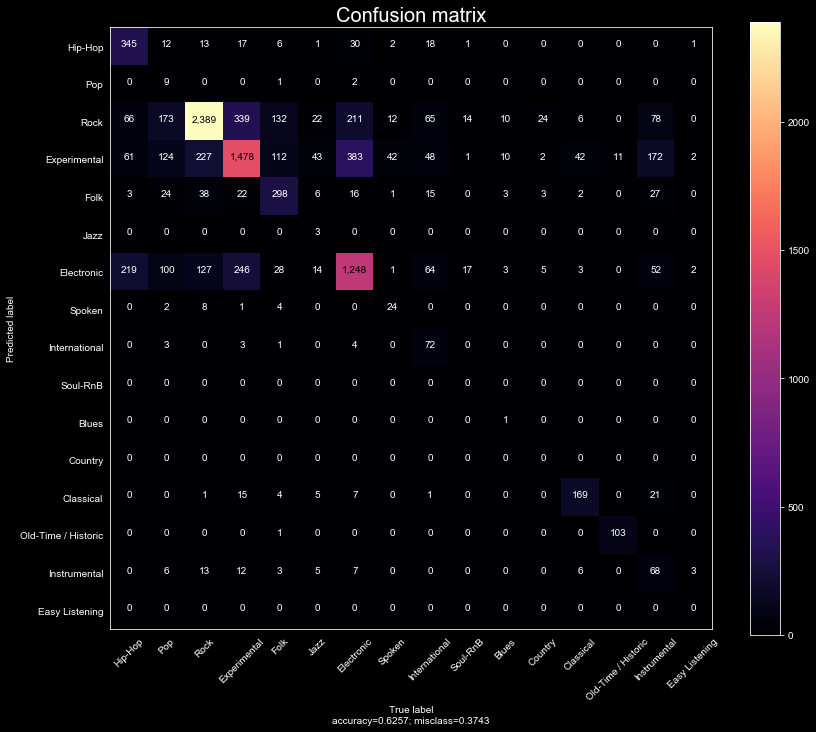

In [136]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    import seaborn as sns
    sns.set_style('dark')
    plt.style.use('dark_background')

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > 1240 else "white")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(rfc_conf_matrix, target_names = with_genres['genre_top'].unique(), 
                      cmap='magma', normalize=False)

In [68]:
# Setting up the model with just the high import cols
X = with_genres[high_import_cols]
Y = with_genres['factorized_genres']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

# Running random forest classifier
classifier = RandomForestClassifier(n_estimators=50, criterion='entropy')
classifier.fit(X_train,Y_train)

classifier.score(X_test, Y_test)

0.6240927419354839

In [69]:
# Setting up a model where X is just rock music
with_genres['rock_encode'] = with_genres['genre_top'].apply(lambda x: 1 if x == 'Rock' else 0)

In [70]:
with_genres[['genre_top', 'rock_encode']]

,genre_top,rock_encode
track_id,,
2,Hip-Hop,0
3,Hip-Hop,0
5,Hip-Hop,0
10,Pop,0
134,Hip-Hop,0
...,...,...
155315,Rock,1
155316,Rock,1
155317,Rock,1


In [71]:
# Setting up the model with just the high import cols and target as just Rock
X = with_genres[high_import_cols]
Y = with_genres['rock_encode']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

# Running random forest classifier
rfclassifier = RandomForestClassifier(n_estimators=75, criterion='entropy')
rfclassifier.fit(X_train,Y_train)

rfclassifier.score(X_test, Y_test)

0.8797379032258065

In [72]:

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4
)

decision_tree.fit(X,Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Rock', 'Other'],
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [ ]:
import xgboost as xgb
model=xgb.XGBClassifier(learning_rate=0.01)
model.fit(X_train, Y_train)
model.score(X_test,Y_test)

In [73]:
# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load('/Users/DanCassin/Development/python/Notebooks/Thinkful/Supervised_Learning_Data/fma_small/009/009555.mp3')

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

/Users/DanCassin/Development/python/python/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Estimated tempo: 143.55 beats per minute


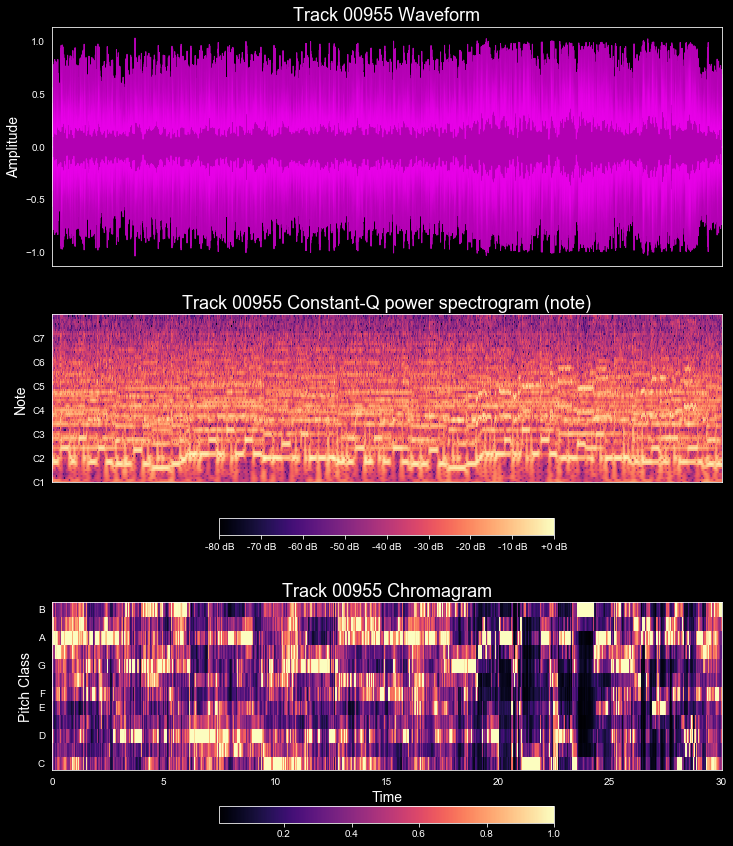

In [90]:
fig,ax = plt.subplots(figsize=(12, 15))

ax1 = plt.subplot(3,1,1)
librosa.display.waveplot(y, sr=sr,alpha=.7, color='magenta')
ax1.set_title('Track 00955 Waveform', fontsize=18)
ax1.set_ylabel('Amplitude', fontsize=14)
ax1.set_xlabel('')

ax2 = plt.subplot(3,1,2)
CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr)), ref=np.max)
librosa.display.specshow(CQT, y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB', orientation='horizontal', shrink=.5)
ax2.set_title('Track 00955 Constant-Q power spectrogram (note)',fontsize=18)
ax2.set_ylabel('Note', fontsize=14)
ax2.set_xlabel('')

ax3 = plt.subplot(3,1,3)
S = np.abs(librosa.stft(y))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar(orientation='horizontal', shrink=.5)
ax3.set_title('Track 00955 Chromagram', fontsize=18)
ax3.set_ylabel('Pitch Class', fontsize=14)
ax3.set_xlabel('Time', fontsize=14);

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

In [87]:
print(f'Feature - Chroma: \n{librosa.feature.chroma_stft(y=y, sr=sr)[0][:12]}')
print(f'Feature - MFCC: \n{librosa.feature.mfcc(y=y, sr=sr)[0][:12]}')
print(f'Feature - Tonal Centroid: \n{librosa.feature.tonnetz(y=y, sr=sr)[0][:12]}')

Feature - Chroma: 
[0.22604746 0.2813215  0.43854785 0.38476217 0.29997423 0.22585545
 0.3071451  0.49568754 0.5070596  0.3791621  0.4562435  0.62668973]
Feature - MFCC: 
[-173.72845    -62.192673   -22.59986    -21.357674   -26.206614
  -35.734097   -37.670322   -21.697405   -10.4489765  -10.636153
  -14.840432   -22.281391 ]
Feature - Tonal Centroid: 
[-0.06236429 -0.02302188 -0.00348127  0.00058128 -0.00780228 -0.02043068
 -0.01287018 -0.02469406 -0.04650844 -0.02041531 -0.01071213 -0.01129399]
